# Examining Green Gentrification in Brooklyn Park, MN
Brooklyn park is the sixth largest city in Minnesota. It is considered a suburb of Minneapolis and is home to atleast 80,000 people. Brooklyn Park is considered to be very diverse with over half of the population considered non-white. It also has more than 60 parks and will soon be home to the new light rail route, connecting it to Minneapolis. 

More information about Brooklyn Park, MN can be found here: https://www.brooklynpark.org/.

### The questions being asked in this study are:
- Which block groups in BP are most vulnerable to gentrification?
- Have green spaces affected property values?
- Has green gentrification possibly occurred in brooklyn park?

## Preprocessing Data
Multiple datasources are used in this project: census data from 2000 and 2018, and shapefiles of block groups from the city and county level. The goal of preprocessing are to query data relevant to the area of interest, calculate normalized percentages for each block group, and create one cohesive dataset to be used for analysis. 

### Preprocessing - Tracts and Geometry

In [1]:
import pyproj
import pandas as pd
import geopandas as gpd
import fiona
import folium
import matplotlib as plt
import shapely
from shapely.geometry import Polygon


In [2]:
# File Pathways
race2000 = pd.read_csv('nhgis0008_ds147_2000_blck_grp.csv') # Population by race data 2000 
mhi2000 = pd.read_csv('nhgis0003_ds152_2000_blck_grp.csv') # median household income and education attainment 2000
hv2000 = pd.read_csv('nhgis0004_ds152_2000_blck_grp.csv') # median house value 2000

edu2018 = pd.read_csv('nhgis0003_ds239_20185_2018_blck_grp.csv') # median household income, median house value, and education attainment 2018
blkg = '2010_BP_blkg.shp' # Block groups in Brooklyn Park
bg_2010 = '053_blkg_2010.shp' # block groups for Hennepin County

parks = ("bp_parks.shp")

In [3]:
with fiona.open(blkg, 'r') as bg:
# obtain census tract codes for Brooklyn Park to query data relevant to area
    tracts = []
    for x in bg:
        t = tracts.append(x['properties']['TRACT'])
            
# remove duplicates from list and convert to a list   
    tracts = list(set(tracts))

In [4]:
# Extract geometry for block groups
pdf = gpd.read_file(parks)
bg = gpd.read_file(bg_2010)
b_geoms = bg[['GISJOIN', 'geometry']]

In [5]:
def tract_clip(filepathway, county):
    df = filepathway.loc[(filepathway['TRACTA'].astype(int).isin(tracts)) & (filepathway['COUNTY'] == county)].copy()
    return df     

### Preprocessing - Parks Brooklyn Park

In [6]:
pk = gpd.read_file(parks)

# Types of green spaces in dataset: Park, School, Special
pk = gpd.read_file(parks)
print(pk["Type"].unique())

# Filter green spaces classified as 'park' and 'special' with 'park' in the name
bp_pk = pk.loc[(pk["Type"] == "Park") ^  ((pk["Type"] == "Special") & (pk["NAME"].str.contains("Park"))) ] 


['Park' 'School' 'Special']


In [7]:
# Check CRS + units: UTM Zone 15N, Units: Meters
print(bp_pk.crs)

# Buffer parks - 0.5 miles (804.672 meters)
bp_pk_buff = bp_pk.buffer(804.672) # geoseries with new buffers

# Set buffered parks to new geometry of parks
bp_pk.set_geometry(bp_pk_buff)

{'init': 'epsg:6344'}


,NAME,Address,Type,Acres,Activities,Amenities,Shape_Leng,Shape_Area,geometry
0,Bass Creek Park,6665 Boone Avenue North,Park,80.683014,"Pickleball Court, Playground, Softball Diamond...","Parking Lots, Trails",16115.066813,3.514538e+06,"POLYGON ((467603.421 4991908.189, 467603.510 4..."
2,Birch Grove Park,4520 81st Avenue North,Park,12.985192,None,None,3249.188742,5.656327e+05,"POLYGON ((472456.669 4994304.563, 472456.487 4..."
3,Brook Oaks Park,1750 87th Trail North,Park,10.343899,"Basketball Full Court, Playground",Trails,3284.533333,4.505785e+05,"POLYGON ((475158.069 4995837.638, 475164.554 4..."
4,Brookdale Park,7650 June Avenue North,Park,180.186093,"Basketball Full Court, Dog Park, Outdoor Hocke...","Activity Building, Parking Lots, Picnic Shelte...",23282.687615,7.848875e+06,"POLYGON ((472608.318 4993443.445, 472608.279 4..."
5,Brookland Golf Park,8232 Regent Avenue,Special,26.377250,None,Activity Building,4811.956430,1.148988e+06,"POLYGON ((472376.251 4993792.996, 472313.859 4..."
6,Brooklyn Acres Park,9161 Hampshire Avenue North,Park,5.452198,Playground,Trails,3626.974166,2.374968e+05,"POLYGON ((470005.066 4996428.795, 469994.810 4..."
8,Cavelle Park,6249 Cavelle Avenue North,Park,9.234819,Playground,Trails,4351.366412,4.022671e+05,"POLYGON ((467946.491 4990658.674, 467949.648 4..."
9,Central Park,8440 Regent Avenue North,Park,47.565864,"Basketball Full Court, Disk Golf Holes, Footba...","Parking Lots, Picnic Shelter, Restroom, Trails",8983.242514,2.071961e+06,"POLYGON ((471964.086 4994599.822, 471960.052 4..."
11,Cherry Meadows Park,6400 Xylon Avenue North,Park,2.331905,None,Trails,1297.259539,1.015774e+05,"POLYGON ((470512.350 4991017.263, 470511.222 4..."
12,City Park,1313 79th Avenue North,Park,2.865026,Playground,Trails,2013.162925,1.248000e+05,"POLYGON ((475738.442 4994027.967, 475747.215 4..."


### Preprocessing - 2000 data

In [8]:
# 2000 data
county = 'Hennepin'

# Population by race data 2000
r_df = tract_clip(race2000, county)

# calculate total number of people in race data for each block group
r_df['total'] = r_df[['FYE001', 'FYE002', 'FYE003', 'FYE004', 'FYE005', 'FYE006', 'FYE007']].astype(int).sum(axis=1)

# calculate total percentage non-whites in each block group
r_df['non_white'] = round(((r_df['total'] - r_df['FYE001'].astype(int)) / r_df['total']), 3) 

# create join list
join1 = r_df[['GISJOIN', 'TRACTA', 'non_white']]

In [9]:
# Median household income and education attainment data 2000
mhi_df = tract_clip(mhi2000, county)

# sum of females and males (age >= 25) with BA
sum_BA = (mhi_df['HD1013'].astype(int) + mhi_df['HD1029'].astype(int)).copy()

# sum of all males and females
sum_edu = (((mhi_df.iloc[:, 13: -4]).astype(int)).sum(axis=1)).copy()

# calculate percentage with BA in each block group
BA_edu = round((sum_BA/sum_edu), 3)

# create column with BA percentage
mhi_df['BA_Edu'] = BA_edu

# rename column for median household income
mhi_df = mhi_df.rename(columns = {'HF6001': 'MHI'})

# create join list
join2 = mhi_df[['TRACTA','BA_Edu', 'MHI']]


In [10]:
# Median house value 2000 in blcok groups
hv00_df = tract_clip(hv2000, county)

# rename column for median household value
hv00_df = hv00_df.rename(columns = {'G8V001': 'MHV_2000'})

# create join list
join3 = hv00_df[['TRACTA','MHV_2000']]


In [11]:
# check that 'GISJOIN' matches in each join dataframe
print(join1['TRACTA'].isin(join2['TRACTA']))

print(join2['TRACTA'].isin(join3['TRACTA']))

1160    True
1161    True
1162    True
1163    True
1164    True
        ... 
1677    True
1678    True
1679    True
1680    True
1681    True
Name: TRACTA, Length: 99, dtype: bool
1160    True
1161    True
1162    True
1163    True
1164    True
        ... 
1677    True
1678    True
1679    True
1680    True
1681    True
Name: TRACTA, Length: 99, dtype: bool


In [12]:
# create one dataframe with relevant columns for 2000
merge1 = join1.join(join2[['BA_Edu', 'MHI']])
merge2 = merge1.join(join3['MHV_2000'])

# dataset for year 2000
d1 = merge2.fillna(0) # replace no data with zero


### Preprocessing - 2018 Data

In [13]:
# 2018 data

county2 = 'Hennepin County'

# Median household income, education attainment, and median house value
e18 = tract_clip(edu2018, county2)

# rename column for median household income
e18 = e18.rename(columns = {'AJZAE001': 'MHI_2018'})

# rename column for median household value
e18 = e18.rename(columns = {'AJ3QE001': 'MHV_2018'})

join6 = e18[['GISJOIN','MHV_2018', 'MHI_2018']]

join6 = join6.fillna(0) # replace no data with zero


In [14]:
# merge dataframes based on GIS JOIN ID. 
data = d1.merge(join6, on='GISJOIN')


In [15]:
# Note: Geopandas was not working for me until 4/27/2020. I added this bit to be able to use gpd. 
# convert dataframe to a geodataframe 
data = gpd.GeoDataFrame(data)

# join data gdf with geometry
data = data.merge(b_geoms, on='GISJOIN')


In [16]:
# View data to ensure all columns are present
data

,GISJOIN,TRACTA,non_white,BA_Edu,MHI,MHV_2000,MHV_2018,MHI_2018,geometry
0,G27005300202001,20200,0.261,0.158,56111,141000,172300.0,0.0,"POLYGON ((477893.616 4990950.770, 477792.962 4..."
1,G27005300202002,20200,0.262,0.175,41042,105100,175700.0,40852.0,"POLYGON ((477460.316 4991074.043, 477463.019 4..."
2,G27005300202003,20200,0.327,0.029,24609,98000,161800.0,31086.0,"POLYGON ((476370.668 4991887.063, 476390.190 4..."
3,G27005300202004,20200,0.235,0.178,55132,111500,142400.0,77000.0,"POLYGON ((476370.668 4991887.063, 476276.458 4..."
4,G27005300202005,20200,0.381,0.220,44712,115900,164900.0,54631.0,"POLYGON ((476763.408 4991885.618, 476669.119 4..."
...,...,...,...,...,...,...,...,...,...
88,G27005300269072,26907,0.053,0.381,85971,195800,255500.0,90750.0,"POLYGON ((469232.774 5000710.167, 469229.864 5..."
89,G27005300269081,26908,0.064,0.198,67083,135700,216900.0,102667.0,"POLYGON ((470073.020 5001499.911, 470069.071 5..."
90,G27005300269082,26908,0.032,0.207,71774,132800,204700.0,72697.0,"POLYGON ((471655.809 5000940.073, 471586.888 5..."
91,G27005300269083,26908,0.044,0.266,65063,134600,207600.0,95129.0,"POLYGON ((471655.809 5000940.073, 471654.122 5..."



### Calculating Gentrification Vulnerability Index

Gentrification is impacted by many variables. Areas more vulnerable to gentrification will have a low bachelor's degree attainment percentage, low median income, and a high racial proportion. I have developed a simple gentrification vulnerability index that is specific to Brooklyn Park, MN. 

To calcuate the score, each demographic variable (Non-white percentage, Bachelor Degree Attainment percentage, and Median Housing Income) was divided into five equal ranges within the minimum and maximum. The ranges were then assigned a score from 1-5. 


In [17]:
# Examine the range of each demographic variable 2010

def df_range(dataframe, column_name):
    df_min = round((dataframe[column_name].min()))
    df_max = round((dataframe[column_name].max()), 3)
    print(column_name, 'min:', df_min, 'max:', df_max)
    
    # create ranges for demographic variable
    df_inc = round(((df_max - df_min)/ 5), 3)
    df_inc1 = round((df_min + df_inc), 3)
    df_inc2 = round((df_min + df_inc *2), 3)
    df_inc3 = round((df_min + df_inc *3), 3)
    df_inc4 = round((df_min + df_inc *4), 3)
    df_inc5 = round((df_min + df_inc *5), 3)
    
    # Print increments for demographic variable
    print('range 1', df_min,'-', df_inc1 )
    print('range 2', (df_min + df_inc + 0.001), '-', df_inc2)
    print('range 3', (df_inc2 + 0.001), '-', df_inc3)
    print('range 4', (df_inc3 + 0.001), '-', df_inc4)
    print('range 5', (df_inc4 + 0.001), '-', df_max)
    
    return df_inc1, df_inc2, df_inc3, df_inc4, df_inc5


Block groups with higher proportions of minority residents are more vulnerable to gentrification. As such the ranges will be given the following non-white scores:

- range 1 - 1
- range 2 - 2
- range 3 - 3
- range 4 - 4
- range 5 - 5

In [18]:
df_range(data, 'non_white')

non_white min: 0.0 max: 0.71
range 1 0.0 - 0.142
range 2 0.143 - 0.284
range 3 0.285 - 0.426
range 4 0.427 - 0.568
range 5 0.569 - 0.71


(0.142, 0.284, 0.426, 0.568, 0.71)

Block groups with higher proportions of residents with bachelor's degrees are less vulnerable to gentrification. As such the ranges will be given the following non-white scores:

- range 1 - 5
- range 2 - 4
- range 3 - 3
- range 4 - 2
- range 5 - 1

In [19]:
df_range(data, 'BA_Edu')

BA_Edu min: 0.0 max: 0.382
range 1 0.0 - 0.076
range 2 0.077 - 0.152
range 3 0.153 - 0.228
range 4 0.229 - 0.304
range 5 0.305 - 0.382


(0.076, 0.152, 0.228, 0.304, 0.38)

In [20]:
df_range(data, 'MHI')

MHI min: 24457 max: 86037
range 1 24457 - 36773.0
range 2 36773.001 - 49089.0
range 3 49089.001 - 61405.0
range 4 61405.001 - 73721.0
range 5 73721.001 - 86037


(36773.0, 49089.0, 61405.0, 73721.0, 86037.0)

Block groups with higher median housing income are less vulnerable to gentrification. As such the ranges will be given the following non-white scores:

- range 1 - 5
- range 2 - 4
- range 3 - 3
- range 4 - 2
- range 5 - 1

In [21]:
#Before running, uncomment variables and fill with target information

#column= ''      # label of column assigning values to based on ranges
#ncol= ''        # label of column for the scores

#up_r1 =         # upper range for interval = df_inc1 for demographic variable
#up_r2 =         # upper range for interval = df_inc2 for demographic variable
#up_r3 =         # upper range for interval = df_inc3 for demographic variable
#up_r4 =         # upper range for interval = df_inc4 for demographic variable
#up_r5 =         # upper range for interval = df_inc5 for demographic variable


In [22]:
column= 'non_white' # label of column assigning values to based on ranges
ncol= 'nw_sc' # label of column for the scores

up_r1 = 0.142
up_r2 = 0.284
up_r3 = 0.426
up_r4 = 0.568
up_r5 = 0.71


r1 = data.loc[(data[column] <= up_r1)].copy()
r1[ncol] = 1

r2 = data.loc[(data[column] > up_r1) & (data[column] <= up_r2)].copy()
r2[ncol] = 2

r3 = data.loc[(data[column] > up_r2) & (data[column] <= up_r3)].copy()
r3[ncol] = 3

r4 = data.loc[(data[column] > up_r3) & (data[column] <= up_r4)].copy()
r4[ncol] = 4

r5 = data.loc[(data[column] > up_r4) & (data[column] <= up_r5)].copy()
r5[ncol] = 5

# Concatenate new score column with full dataset
dataframes = [r1, r2, r3, r4, r5]
r = pd.concat(dataframes)
data = data.merge(r[['GISJOIN', ncol]], on='GISJOIN')

In [23]:
column= 'BA_Edu' # label of column assigning values to based on ranges
ncol= 'ba_sc' # label of column for the scores

up_r1 = 0.076
up_r2 = 0.152
up_r3 = 0.228
up_r4 = 0.304
up_r5 = 0.38

r1 = data.loc[(data[column] <= up_r1)].copy()
r1[ncol] = 1

r2 = data.loc[(data[column] > up_r1) & (data[column] <= up_r2)].copy()
r2[ncol] = 2

r3 = data.loc[(data[column] > up_r2) & (data[column] <= up_r3)].copy()
r3[ncol] = 3

r4 = data.loc[(data[column] > up_r3) & (data[column] <= up_r4)].copy()
r4[ncol] = 4

r5 = data.loc[(data[column] > up_r4) & (data[column] <= up_r5)].copy()
r5[ncol] = 5

# Concatenate new score column with full dataset
dataframes = [r1, r2, r3, r4, r5]
r = pd.concat(dataframes)
data = data.merge(r[['GISJOIN', ncol]], on='GISJOIN')

In [24]:
column= 'MHI' # label of column assigning values to based on ranges
ncol= 'mhi_sc' # label of column for the scores

up_r1 = 36773.0
up_r2 = 49089.0
up_r3 = 61405.0
up_r4 = 73721.0
up_r5 = 86037.0

r1 = data.loc[(data[column] <= up_r1)].copy()
r1[ncol] = 1

r2 = data.loc[(data[column] > up_r1) & (data[column] <= up_r2)].copy()
r2[ncol] = 2

r3 = data.loc[(data[column] > up_r2) & (data[column] <= up_r3)].copy()
r3[ncol] = 3

r4 = data.loc[(data[column] > up_r3) & (data[column] <= up_r4)].copy()
r4[ncol] = 4

r5 = data.loc[(data[column] > up_r4) & (data[column] <= up_r5)].copy()
r5[ncol] = 5

# Concatenate new score column with full dataset
dataframes = [r1, r2, r3, r4, r5]
r = pd.concat(dataframes)
data = data.merge(r[['GISJOIN', ncol]], on='GISJOIN')

In [25]:
# Sum all score columns to obtain gentrifcation vulnerability index score (gvi)
data['gvi'] = data['nw_sc'] + data['ba_sc'] + data['mhi_sc']

# Number of block groups in dataset: 91
data

,GISJOIN,TRACTA,non_white,BA_Edu,MHI,MHV_2000,MHV_2018,MHI_2018,geometry,nw_sc,ba_sc,mhi_sc,gvi
0,G27005300202001,20200,0.261,0.158,56111,141000,172300.0,0.0,"POLYGON ((477893.616 4990950.770, 477792.962 4...",2,3,3,8
1,G27005300202002,20200,0.262,0.175,41042,105100,175700.0,40852.0,"POLYGON ((477460.316 4991074.043, 477463.019 4...",2,3,2,7
2,G27005300202003,20200,0.327,0.029,24609,98000,161800.0,31086.0,"POLYGON ((476370.668 4991887.063, 476390.190 4...",3,1,1,5
3,G27005300202004,20200,0.235,0.178,55132,111500,142400.0,77000.0,"POLYGON ((476370.668 4991887.063, 476276.458 4...",2,3,3,8
4,G27005300202005,20200,0.381,0.220,44712,115900,164900.0,54631.0,"POLYGON ((476763.408 4991885.618, 476669.119 4...",3,3,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,G27005300269071,26907,0.073,0.331,69329,176500,337100.0,110417.0,"POLYGON ((469254.092 5001525.487, 469253.901 5...",1,5,4,10
87,G27005300269081,26908,0.064,0.198,67083,135700,216900.0,102667.0,"POLYGON ((470073.020 5001499.911, 470069.071 5...",1,3,4,8
88,G27005300269082,26908,0.032,0.207,71774,132800,204700.0,72697.0,"POLYGON ((471655.809 5000940.073, 471586.888 5...",1,3,4,8
89,G27005300269083,26908,0.044,0.266,65063,134600,207600.0,95129.0,"POLYGON ((471655.809 5000940.073, 471654.122 5...",1,4,4,9


## Analysis and vizualizations

Gentrification Vulnerability Index Interpretation:
- 3-6 = low vulnerability
- 7-9 = medium vulnerability
- 10-15 = high vulnerability

In [26]:
# create a function to return number of block groups in interested vulnerability level
# level = 'low', 'medium', or 'high'
# u_lim = upper range of level
# l_lim = lower range of level

def gvi_classification(level, u_lim, l_lim):
    lvl = data.loc[(data['gvi'] <= u_lim) & (data['gvi'] >= l_lim)]
    print(level, 'vulnerability')
    print('Number of block groups:', len(lvl))
    
# count of block groups considered low vulnerability
gvi_classification('low', 6, 3)

# count of block groups considered medium vulnerability
gvi_classification('medium', 9, 7)

# count of block groups considered high vulnerability
gvi_classification('high', 15, 10)

low vulnerability
Number of block groups: 14
medium vulnerability
Number of block groups: 58
high vulnerability
Number of block groups: 19


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D89822F9E8>]],
      dtype=object)

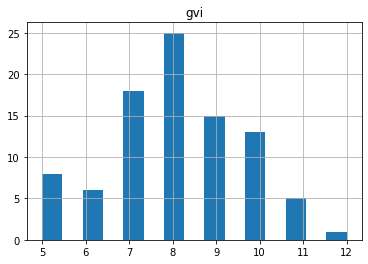

In [27]:
# Visualize distribution of gvi scores
# 
data.hist(column='gvi', grid=True, bins=15)

In [28]:
# Map of all block groups in dataset 
m = folium.Map(location = [45.111221, -93.347873], zoom_start = 10.5 )

data.crs = 'EPSG:32615'

folium.GeoJson(data).add_to(m)


c:\Anaconda3_5.2_Python3.6\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [29]:
m

##### The histogram shows the peak is at 8 and gvi scores range from 5 to 12. 

Maximum change: 0.954
Minimum change: -1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D8986CACC0>]],
      dtype=object)

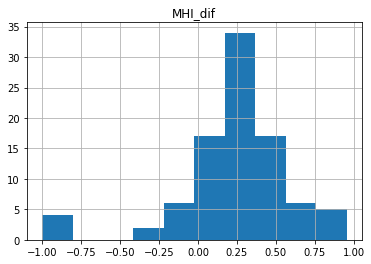

In [30]:
# calculate the change in median household income in 2018 compared to 2000. 
data['MHI_dif'] = round((data['MHI_2018'] - data['MHI']) / (data['MHI']), 3) 

# give statistics about the differences
print('Maximum change:', data['MHI_dif'].max())
print('Minimum change:', data['MHI_dif'].min())

# visualize the distribution of MHI changes
data.hist(column='MHI_dif')

##### The histogram of the Median Housing Difference shows a large count of block groups (~34 out of  have seen a 25% increase in median housing income. The dataset used to calculate this is already corrected for inflation through the years and thus inflation is not affecting the median housing income. 

Maximum change: 2.524
Minimum change: 0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D899731320>]],
      dtype=object)

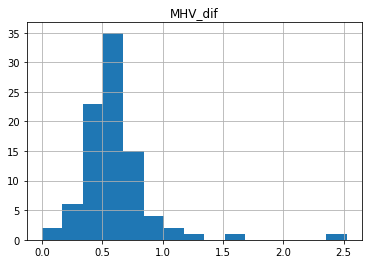

In [31]:
# calculate the change in median housing value in 2018 compared to 2000
data['MHV_dif'] = round((data['MHV_2018'] - data['MHV_2000'])/ (data['MHV_2000']), 3)

# give statistics about the differences
print('Maximum change:', data['MHV_dif'].max())
print('Minimum change:', data['MHV_dif'].min())

# visualize the distribution of MHI changes
data.hist(column='MHV_dif', bins=15)


##### The median housing value shows that the majority of census blocks had atleast a 50% increase.

## Analysis 

### Which block groups in BP are most vulnerable to gentrification?

In [32]:
# Returns a dataframe of block groups with high GVI - indicating most vulnerable to gentrification
high_gvi = data.loc[(data['gvi'] <= 15) & (data['gvi'] >= 10)]


In [33]:
# Create map of high GVI block groups
mh = folium.Map(location = [45.111221, -93.347873], zoom_start = 10.5 )

folium.GeoJson(high_gvi).add_to(mh)

c:\Anaconda3_5.2_Python3.6\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [34]:
mh

### Have green spaces affected property values?

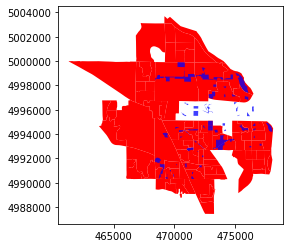

In [35]:
# Plot all block groups and parks 
v1 = bp_pk['geometry']
v2 = data['geometry']

gsp = v2.plot(color='red')
v1.plot(ax=gsp, color='blue', alpha=0.75)


In [36]:
# identify block groups which intersect park buffer 
park_hv = data.loc[(data.intersects(v1.unary_union) ==True)]
print('Block groups intersecting with parks:', len(park_hv))

Block groups intersecting with parks: 36


In [37]:
# Create map of high GVI block groups
mp = folium.Map(location = [45.111221, -93.347873], zoom_start = 12)

folium.GeoJson(park_hv).add_to(mp)
mp

c:\Anaconda3_5.2_Python3.6\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D8998BFE80>]],
      dtype=object)

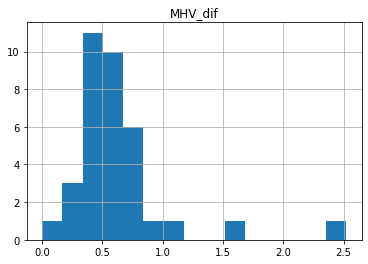

In [38]:
# Examine the housing value differences distribution of block groups surrounding parks
park_hv.hist(column='MHV_dif', bins=15)

### Has green gentrification possibly occurred in brooklyn park?

In [39]:
# Conditions: gvi >= 10 (high vulnerability), MHV_dif >= .40
gvi_threshold = 10
MHV_dif_threshold = 0.4

gc = data.loc[(data['gvi'] >= gvi_threshold) & (data['MHV_dif'] >= MHV_dif_threshold)].copy() # gentrification block group candidates


In [40]:
# Assign geometry to new variables 
poly1 = gc['geometry']
poly2 = bp_pk['geometry']


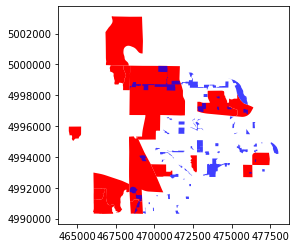

In [41]:
# Plot park buffers and census block groups with high gvi and great MHV difference
ax = poly1.plot(color='red') # gentrification block group candidates
poly2.plot(ax=ax, color='blue', alpha=0.75); # Brooklyn Park parks

In [42]:
# identify which gentrification block group candidates intersect park buffer
g = gc.loc[(poly1.intersects(poly2.unary_union) ==True)]
print('Potential Green Gentrification Block Group Count:', len(g))
g

Potential Green Gentrification Block Group Count: 9


,GISJOIN,TRACTA,non_white,BA_Edu,MHI,MHV_2000,MHV_2018,MHI_2018,geometry,nw_sc,ba_sc,mhi_sc,gvi,MHI_dif,MHV_dif
25,G27005300267063,26706,0.037,0.275,76048,137100,263300.0,98750.0,"POLYGON ((468401.773 4998327.970, 468397.606 4...",1,4,5,10,0.299,0.920
43,G27005300268075,26807,0.163,0.207,78446,141500,225900.0,80750.0,"POLYGON ((469213.389 4991128.114, 469215.983 4...",2,3,5,10,0.029,0.596
44,G27005300268076,26807,0.190,0.235,64886,131100,226400.0,83667.0,"POLYGON ((468874.155 4995320.144, 468878.363 4...",2,4,4,10,0.289,0.727
57,G27005300268123,26812,0.220,0.350,73233,159300,412200.0,95833.0,"POLYGON ((471975.305 4996698.263, 471959.094 4...",2,5,4,11,0.309,1.588
58,G27005300268141,26814,0.353,0.217,69922,120700,170300.0,0.0,"POLYGON ((476357.416 4992684.631, 476232.530 4...",3,3,4,10,-1.000,0.411
65,G27005300268153,26815,0.291,0.161,66190,131900,195600.0,99079.0,"POLYGON ((477168.384 4993474.191, 477142.575 4...",3,3,4,10,0.497,0.483
74,G27005300268183,26818,0.303,0.168,63194,120800,178900.0,71600.0,"POLYGON ((471162.544 4992911.115, 471162.886 4...",3,3,4,10,0.133,0.481
79,G27005300268202,26820,0.174,0.339,73417,140600,214100.0,107500.0,"POLYGON ((476416.177 4997198.483, 476267.012 4...",2,5,4,11,0.464,0.523
80,G27005300268203,26820,0.285,0.332,72243,167600,293600.0,127794.0,"POLYGON ((474835.130 4997523.933, 474834.628 4...",3,5,4,12,0.769,0.752


In [43]:

m2 = folium.Map(location = [45.111221, -93.347873], zoom_start = 10.5 )

g.crs = 'EPSG:32615'

folium.GeoJson(g).add_to(m2)


c:\Anaconda3_5.2_Python3.6\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [44]:
# Display map all of the block groups in dataset on left 
#and block groups have high gvi, high MHV change,
#and are within 0.5 miles of existing parks. 

from IPython.core.display import display, HTML

compare = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(m.get_root().render().replace('"', '&quot;'),400,400,
                   m2.get_root().render().replace('"', '&quot;'),400,400))
display(compare)

c:\Anaconda3_5.2_Python3.6\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Data sources:
Steven Manson, Jonathan Schroeder, David Van Riper, and Steven Ruggles. IPUMS National Historical Geographic Information System: Version 14.0 [Database]. Minneapolis, MN: IPUMS. 2019. http://doi.org/10.18128/D050.V14.0